Experimenting with estimating the gender of mailing list participants.

In [1]:
%matplotlib inline

In [2]:
from bigbang.listserv import ListServ
import bigbang.mailman as mailman
import bigbang.process as process
from bigbang.archive import Archive
import imp
imp.reload(process)

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import math
import pytz
import pickle
import os

from bigbang import parse
from gender_detector import gender_detector as gd

/home/christovis/02_AGE/datactive/bigbang/config/config.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dictionary = yaml.load(stream)


In [3]:
adirs = ["/home/christovis/02_AGE/datactive/bigbang/archives/3GPP_TSG_SA_WG2_PROSE_GCSE_LTE/"]
file_dscs = [{"root": "", "extension": "LOG"}]

mlists = [(adirs[0].split("/")[-2], ListServ.from_archives(adirs, file_dscs).data)]

In [4]:
detector = gd.GenderDetector('us')

gender_ambiguous_names = {}

def guess_gender(name):
    if not name:
        return 'name unknown'
    try:
        if detector.guess(name) == 'unknown':
            if name in gender_ambiguous_names:
                gender_ambiguous_names[name] += 1
            else:
                gender_ambiguous_names[name] = 1
        
        return detector.guess(name)
    except:
        return 'error'

def ml_shortname(url):
    return url.rstrip("/").split("/")[-1]

series = []  
for (url, ml) in mlists:
    activity = Archive.get_activity(Archive(ml)).sum(0)
    activityFrame = pd.DataFrame(activity, columns=['Message Count'])
    
    activityFrame['Name'] = activityFrame.index.map(lambda x: parse.clean_from(x))    
    activityFrame['First Name'] = activityFrame['Name'].map(lambda x: parse.guess_first_name(x))
    activityFrame['Guessed Gender'] = activityFrame['First Name'].map(guess_gender)
    
    activityFrame.to_csv(('senders_guessed_gender-%s.csv' % ml_shortname(url)),encoding='utf-8')
    
    counts = activityFrame.groupby('Guessed Gender')['Message Count'].count()
    counts.name=url
    series.append(counts)

pd.DataFrame(series)

Guessed Gender,female,male,name unknown,unknown
3GPP_TSG_SA_WG2_PROSE_GCSE_LTE,4,19,13,30


<AxesSubplot:>

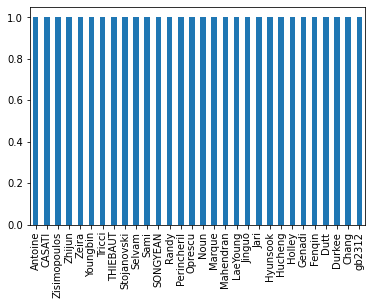

In [5]:
ser = pd.Series(gender_ambiguous_names)
ser.sort_values(ascending=False).plot(kind='bar')

In [6]:
url = "http://lists.w3.org/Archives/Public/public-privacy/"
csv_guessed = ('senders_guessed_gender-%s.csv' % ml_shortname(url))
csv_manual = ('senders_manual_gender-%s.csv' % ml_shortname(url))

guessed = pd.read_csv(csv_guessed)
manual = pd.read_csv(csv_manual)

<AxesSubplot:>

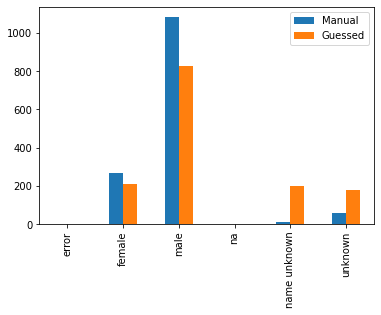

In [7]:
def combined_gender(row):
    if str(row['Manual Gender']) != 'nan':
        return row['Manual Gender']
    else:
        return row['Guessed Gender']
manual['Combined Gender'] = manual.apply(combined_gender, axis=1)

combined_series = manual.groupby('Combined Gender')['Message Count'].sum()
guessed_series = manual.groupby('Guessed Gender')['Message Count'].sum()
compared_counts = pd.DataFrame({'Manual':combined_series, 'Guessed':guessed_series})
compared_counts.plot(kind='bar')